In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import Tensor, nn
from torchvision.utils import make_grid


In [ ]:
def save_samples(
    model: nn.Module,
    device: torch.device,
    filepath: str,
    num_samples: int = 64,
    latent_dim: int = 2,
    condition_dim: int = 10,
    use_conv: bool = False,
):
    model.eval()
    with torch.no_grad():
        # Create one-hot encoded conditions for each digit
        samples_per_digit = num_samples // 10
        conditions = []

        for digit in range(10):
            condition = torch.zeros(samples_per_digit, condition_dim)
            condition[:, digit] = 1.0
            conditions.append(condition)

        condition = torch.cat(conditions, dim=0).to(device)

        # Sample from latent space
        z = torch.randn(condition.size(0), latent_dim).to(device)

        # Generate samples
        samples = model.decode(z, condition)

        if not use_conv:
            samples = samples.view(-1, 1, 28, 28)

        # Save samples
        save_image(samples, filepath, nrow=10)
        print(f"Samples saved to {filepath}")


def save_image(tensor: Tensor, filepath: str, nrow: int = 8):  # noqa: ARG001
    grid = make_grid(tensor, nrow=nrow, padding=2, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))
    plt.axis("off")
    # plt.savefig(filepath, bbox_inches="tight")  # noqa: ERA001
    plt.show()
    plt.close()


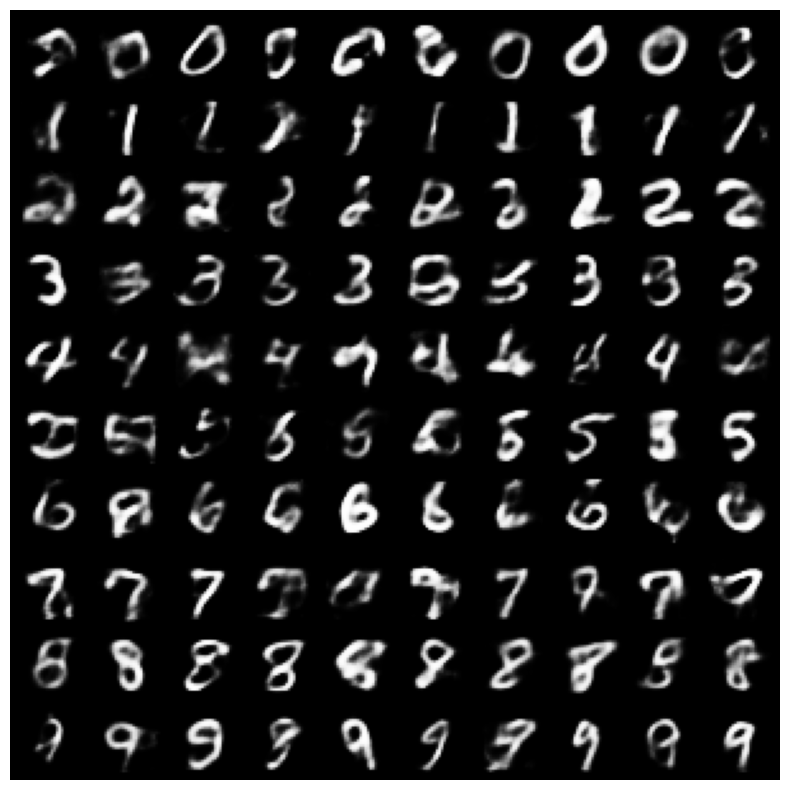

Samples saved to vae_samples.png


In [ ]:
from src.models import ConditionalVAE

latent = 20

model = ConditionalVAE(
    input_dim=784,
    condition_dim=10,
    hidden_dim=512,
    latent_dim=latent,
)


checkpoint = torch.load(
    f"/v/raid1b/backup/hhisham/Courses/PDL/CS_6956_HW3/checkpoints/mnist_latent{latent}_hidden512.pt",
    map_location=torch.device("cuda"),
)

# Extract just the model state dict from the checkpoint
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# call the save_samples function
save_samples(
    model=model,
    device=device,
    filepath="vae_samples.png",
    num_samples=100,
    latent_dim=latent,
    condition_dim=10,
    use_conv=False,
)